In [1]:
from pyDOE import *
import matplotlib.pyplot as plt# Standard imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns 

# Fixing random state for reproducibility
np.random.seed(19680801)

In [2]:
import pickle as pkl

In [3]:
# Initialize the NASBench object which parses the raw data into memory (this
# should only be run once as it takes up to a few minutes).
from nasbench import api

path_to_nasbench_data_full ='/local_home/trao_ka/data/nasbench_full.tfrecord'
#path_to_nasbench_data_full = '/media/kalifou/SAMSUNG1/DLR_DAAD_Research_Backup/data/nasbench_full.tfrecord'

# Use nasbench_full.tfrecord for full dataset (run download command above).
nasbench = api.NASBench(path_to_nasbench_data_full)
#('/home/kalifou/Documents/dlr/data/nasbench_full.tfrecord')

/local_home/trao_ka/anaconda3/envs/nas_data_driven_init/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/local_home/trao_ka/anaconda3/envs/nas_data_driven_init/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/local_home/trao_ka/anaconda3/envs/nas_data_driven_init/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16"




Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


/local_home/trao_ka/anaconda3/envs/nas_data_driven_init/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/local_home/trao_ka/anaconda3/envs/nas_data_driven_init/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/local_home/trao_ka/anaconda3/envs/nas_data_driven_init/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Loaded dataset in 161 seconds


In [4]:

# Useful constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # Upper triangular matrix
OP_SPOTS = NUM_VERTICES - 2   # Input/output vertices are fixed
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix

In [5]:
def sample_single_op(NUM_VERTICES, ALLOWED_OPS):
    x = lhs(NUM_VERTICES, samples=1)[0]
    vv = np.floor(x * len(ALLOWED_OPS))
    op  = [ALLOWED_OPS[int(k)] for k in vv]
    op[0] = INPUT
    op[-1] = OUTPUT
    return op

def sample_single_configurations_lhs(N_dimensions):    
    
    sum_edges = 0   
    while sum_edges != 9:
        v_m = lhs(N_dimensions, samples=1)
        idx = v_m > 0.5
        v_m[idx == True] = 1
        v_m[idx == False] = 0
        sum_edges = sum(v_m[0])
    
    return v_m[0]

def recover_incidence_matrix(a0, N_l=7):
    
    mat = np.zeros((N_l, N_l))
    idx_new = 0
    idx_old = 0
    
    for i in range(N_l):
        idx_new += N_l - i - 1
        
        values = a0[idx_old:idx_new]
        idx_old = idx_new
        mat[i, i+1: ] = values
        
    return mat

def sample_single_valid_spec(NUM_vert, allowed_ops):
    
    is_valid = False
    while not is_valid:
        current_op = sample_single_op(NUM_vert, allowed_ops)
        current_config = sample_single_configurations_lhs(N_dimensions = 7 * 3) 
        current_mat = recover_incidence_matrix(current_config, N_l=NUM_vert)
        current_spec = api.ModelSpec(matrix=current_mat, ops=current_op)        
        is_valid = nasbench.is_valid(current_spec)
        
    return current_mat, current_op, current_spec

def LHS_sample_N_valid_specs(N, NUM_vert, allowed_ops, nb):
 all_specs = []
 set_mats = set()
 while len(set_mats) < N:
   s = sample_single_valid_spec(NUM_vert, allowed_ops)
   m, o, sp = s
   t_m = tuple(m.reshape(NUM_vert * NUM_vert))
   hash_m = nb._hash_spec(sp)
   if hash_m not in set_mats:
     set_mats = set_mats | set([t_m])
     all_specs.append(s)

 return all_specs

In [68]:
def random_spec():
  """Returns a random valid spec."""
  while True:
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
    matrix = np.triu(matrix, 1)
    ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
    ops[0] = INPUT
    ops[-1] = OUTPUT
    spec = api.ModelSpec(matrix=matrix, ops=ops)
    if nasbench.is_valid(spec):
      return matrix, ops, spec

# CLUSTERING

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from kneed import KneeLocator

from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, Birch
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [8]:
MAX_NODES = 7
MAX_EDGES = 9
NASBENCH_TFRECORD = './data/nasbench_full.tfrecord'

INPUT = 'input'
OUTPUT = 'output'
CONV1X1 = 'conv1x1-bn-relu'
CONV3X3 = 'conv3x3-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'

CODING = [INPUT]
CODING = CODING + [CONV1X1 + "_" + str(i) for i in range(0, (MAX_NODES - 2))]
CODING = CODING + [CONV3X3 + "_" + str(i) for i in range(0, (MAX_NODES - 2))]
CODING = CODING + [MAXPOOL3X3 + "_" + str(i) for i in range(0, (MAX_NODES - 2))]
CODING = CODING + [OUTPUT]

In [9]:
def rename_ops(ops):
    c1x1 = 0
    c3x3 = 0
    mp3x3 = 0
    new_ops = []
    for op in ops:
        if op == CONV1X1:
            new_ops = new_ops + [op + "_" + str(c1x1)]
            c1x1 = c1x1 + 1
        elif op == CONV3X3:
            new_ops = new_ops + [op + "_" + str(c3x3)]
            c3x3 = c3x3 + 1
        elif op == MAXPOOL3X3:
            new_ops = new_ops + [op + "_" + str(mp3x3)]
            mp3x3 = mp3x3 + 1
        else:
            new_ops = new_ops + [op]
    return new_ops



def encode_matrix_fixed_long(adj_matrix, ops):
    enc_matrix = np.zeros((len(CODING), len(CODING)))
    pos = [CODING.index(op) for op in ops]
    trans = dict()
    for i, ix in enumerate(pos):
        trans[i] = ix
    i, j = np.nonzero(adj_matrix)
    ix = [trans.get(n) for n in i]
    jy = [trans.get(n) for n in j]
    for p in zip(ix, jy):
        enc_matrix[p] = 1
    
    #print(enc_matrix)
    
    # Flattenning in C (row-major) ording
    encoded =  enc_matrix.flatten('C') 
    #enc_matrix[np.triu_indices(len(CODING), k=1)]
    return encoded.astype(int)


def rename_ops_fixed(ops):
    c1x1 = 0
    c3x3 = 0
    mp3x3 = 0
    new_ops = []
    for op in ops:
        if op == CONV1X1:
            new_ops = new_ops + [op + "_" + str(c1x1)]
            c1x1 = c1x1 + 1
        elif op == CONV3X3:
            new_ops = new_ops + [op + "_" + str(c3x3)]
            c3x3 = c3x3 + 1
        elif op == MAXPOOL3X3:
            new_ops = new_ops + [op + "_" + str(mp3x3)]
            mp3x3 = mp3x3 + 1
        else:
            new_ops = new_ops + [op]
    return new_ops

In [10]:
N_samples = 10000
extra_specs = list()
for iter in range(N_samples):
    spec = random_spec()
    extra_specs.append(spec)

In [11]:
models_and_perfs_all_epochs = list()

binary_and_perfs_all_epochs = list()

for m, o, cell in extra_specs:
    # Query an Inception-like cell from the dataset.
    cell = api.ModelSpec(
      matrix= m.astype(int),
      # Operations at the vertices of the module, matches order of matrix.
      ops= o) #[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])
    local_perfs = []
    for N_epochs in [4, 12, 36, 108]:
        data = nasbench.query(cell, epochs=N_epochs)
        local_perfs.append(data['test_accuracy'])
    
    #################
    ### mat + perfs@4,12,36,108
    
    vectorized_ops = list()

    for item in o:
        if item == CONV3X3:
          vectorized_ops.append(4)  
        elif item == CONV1X1:
          vectorized_ops.append(5)  
        elif item == MAXPOOL3X3:
          vectorized_ops.append(6)  
        else:
            pass
    
    
    #print(local_perfs)
    feature_mat_and_perfs = list(m.flatten('C')) + vectorized_ops + local_perfs
    models_and_perfs_all_epochs.append(feature_mat_and_perfs)
    
    
    ops = rename_ops_fixed(o)
    binary_i = encode_matrix_fixed_long(m, ops)
    #print(binary_i)
    feature_binary_and_perfs = list(binary_i) + vectorized_ops + local_perfs
    binary_and_perfs_all_epochs.append(feature_binary_and_perfs)


# By Number of Components

In [12]:
feature_array = np.array(models_and_perfs_all_epochs)


scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_array)
feature_array.shape, 7*7+4

((10000, 58), 53)

In [13]:
feature_binary_array = np.array(binary_and_perfs_all_epochs)

scaler = StandardScaler()
scaled_features_binary = scaler.fit_transform(feature_binary_array)

feature_binary_array.shape, 17*17+4

((10000, 298), 293)

In [ ]:
n_clusters = 10
n_components = 2

all_scores = dict()

all_scores['pca'] = dict()
all_scores['pca']['original'] = None
all_scores['pca']['binary'] = None

all_scores['truncated_svd'] = dict()
all_scores['truncated_svd']['original'] = None
all_scores['truncated_svd']['binary'] = None

# PCA

In [ ]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       )
   ]
)

In [ ]:
preprocessor = Pipeline(
    [
        #("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=n_components, random_state=42)),
    ]
)

In [ ]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [ ]:
feature_array.shape

# Truncated SVD

In [ ]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       )
   ]
)

In [ ]:
preprocessor = Pipeline(
    [
        ("truncated_svd", TruncatedSVD(n_components=n_components, n_iter=7, 
                                       random_state=42)),
    ]
)

In [ ]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [ ]:
feature_array.shape

# By Number of Clusters

In [ ]:
Max_N_clusters = 45
step = 3
n_components = 2

In [ ]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=2,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       )
   ]
)

In [ ]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 50,
    "max_iter": 500,
    "random_state": 42,
}

In [ ]:
preprocessor = Pipeline(
    [
        ("truncated_svd", TruncatedSVD(n_components=n_components, n_iter=7, 
                                       random_state=42)),
    ]
)

In [ ]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [ ]:
all_scores_by_n_clusters = []

# Qualitative Analysis

## Using the Original Encoding

In [14]:
n_clusters = 27
n_components = 2

In [15]:
Algos = [(
           "KMEANS",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
       
       (
           "SPECTRAL",
           SpectralClustering(n_clusters=n_clusters,
               random_state=42),
       ),
       
       (
           "DBSCAN",
           DBSCAN(eps=0.30, min_samples=200),
       ),
        (
           "BIRCH",
           Birch(n_clusters=n_clusters, threshold=0.12),
       ),
        (
           "BGM",
           BayesianGaussianMixture(n_components=n_clusters, covariance_type='full',
           random_state=42,
           weight_concentration_prior_type="dirichlet_distribution",
           max_iter=500,
                                  )
       ),    
    
]

In [16]:
algo_labels = ["KMEANS", "SPECTRAL", "DBSCAN", "BIRCH", "BGM"]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


(27, 2) 18


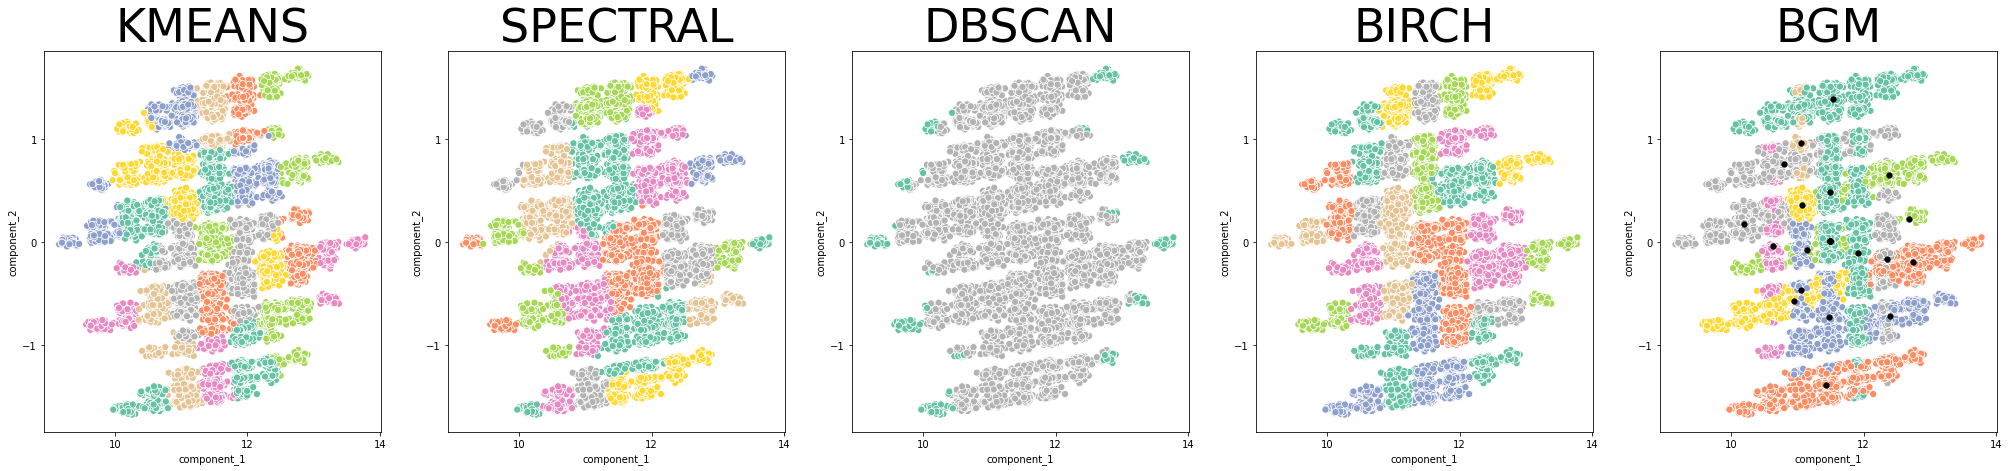

In [17]:
n_plots = len(algo_labels)

fig, axes = plt.subplots(nrows=1, ncols=n_plots, figsize=(7 * n_plots, 7))
plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 32})

for i_algo, algo in enumerate(Algos):

    preprocessor = Pipeline(
        [
            ("truncated_svd", TruncatedSVD(n_components=n_components, n_iter=7, 
                                           random_state=42)),    ]
    )


    clusterer = Pipeline(
       [
           algo
       ]
    )


    pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clusterer", clusterer)
        ]
    )

    data = feature_array
    pipe.fit(data)


    pcadf = pd.DataFrame(
        pipe["preprocessor"].transform(data),
        columns=["component_1", "component_2"],
    )
    
    predicted_labels = None
    
    if "BGM" in algo_labels[i_algo]:
        predicted_labels =  pipe["clusterer"][algo_labels[i_algo]].predict(pipe["preprocessor"].transform(data))
    else:
        predicted_labels = pipe["clusterer"][algo_labels[i_algo]].labels_
        
    pcadf["predicted_cluster"] = predicted_labels

    
   

    scat = sns.scatterplot(
        "component_1",
        "component_2",
        s=50,
        data=pcadf,
        hue="predicted_cluster",
        palette="Set2", ax=axes[i_algo],
    )

    scat.set_title(
        algo_labels[i_algo]
    )

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    axes[i_algo].get_legend().set_visible(False)
    
    
    
    if "BGM" in algo_labels[i_algo]:
        
        import scipy
        
        gmm = pipe["clusterer"][algo_labels[i_algo]]
        X = pipe["preprocessor"].transform(data)
        
        centers = np.empty(shape=(gmm.n_components, X.shape[1]))
        
        for i in range(gmm.n_components):
            density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
            centers[i, :] = X[np.argmax(density)]
        plt.scatter(centers[:, 0], centers[:, 1], s=32, c="k")
        
        print(centers.shape, len(set(predicted_labels)))
    
    
plt.show()

# Binary Encoding

In [18]:
n_clusters = 20
n_components = 2





No handles with labels found to put in legend.


KMEANS (27, 2)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


(27, 2) 15


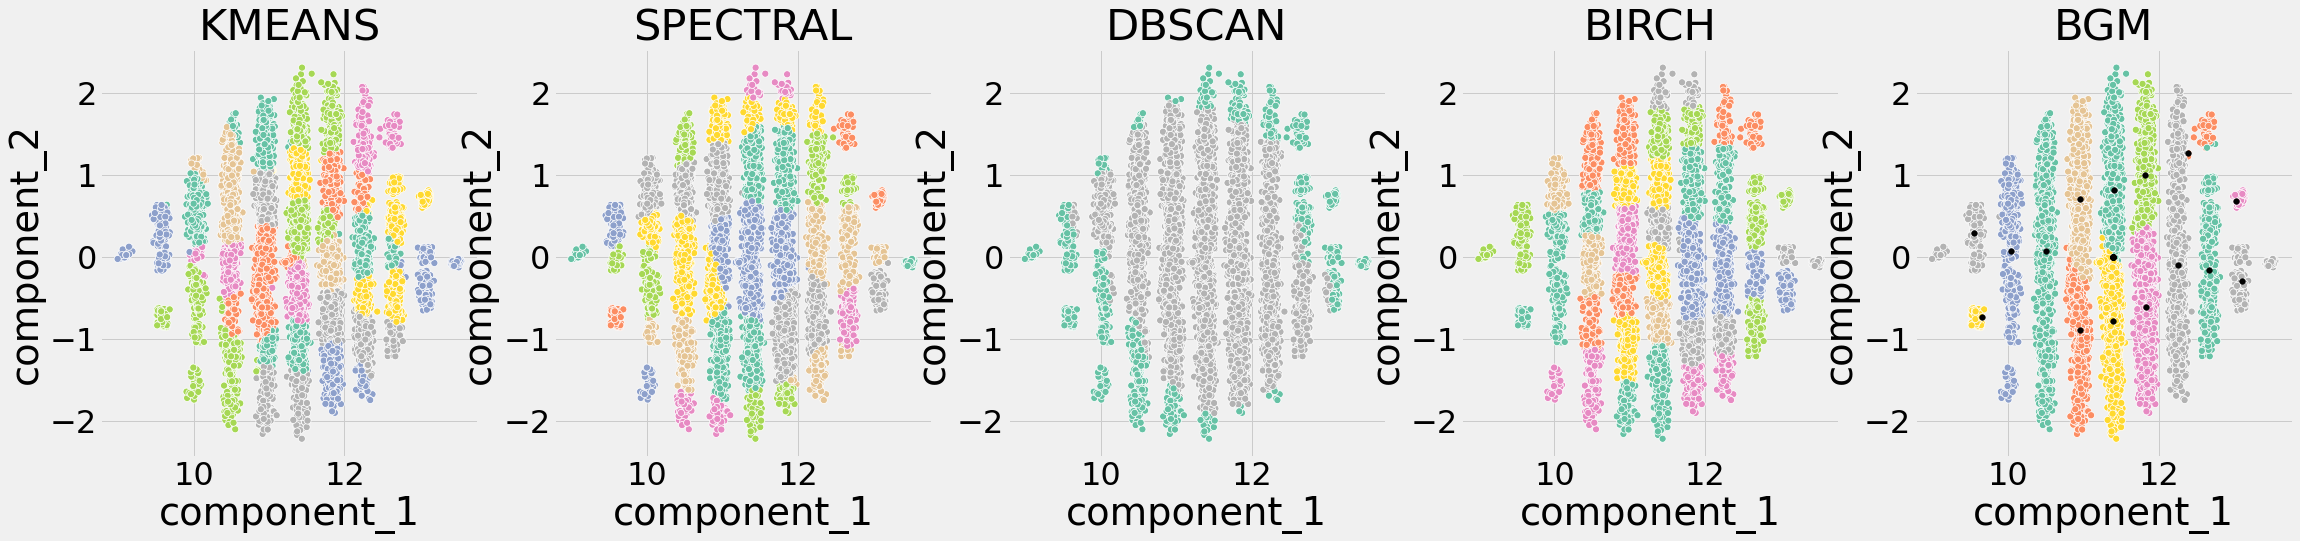

In [19]:
n_plots = len(algo_labels)
fig, axes = plt.subplots(nrows=1, ncols=n_plots, figsize=(7 * n_plots, 7))
plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 30})

for i_algo, algo in enumerate(Algos):

    preprocessor = Pipeline(
        [
            ("truncated_svd", TruncatedSVD(n_components=n_components, n_iter=7, 
                                           random_state=42)),    ]
    )


    clusterer = Pipeline(
       [
           algo
       ]
    )


    pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clusterer", clusterer)
        ]
    )

    data = feature_binary_array
    pipe.fit(data)


    pcadf = pd.DataFrame(
        pipe["preprocessor"].transform(data),
        columns=["component_1", "component_2"],
    )

    predicted_labels = None
    
    if "BGM" in algo_labels[i_algo]:
        predicted_labels =  pipe["clusterer"][algo_labels[i_algo]].predict(pipe["preprocessor"].transform(data))
    else:
        predicted_labels = pipe["clusterer"][algo_labels[i_algo]].labels_
        
    pcadf["predicted_cluster"] = predicted_labels

    #import ipdb
    #ipdb.set_trace()
    
    scat = sns.scatterplot(
        "component_1",
        "component_2",
        s=50,
        data=pcadf,
        hue="predicted_cluster",
        palette="Set2", ax=axes[i_algo], #Paired
    )

    scat.set_title(
        algo_labels[i_algo]
    )

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    axes[i_algo].get_legend().set_visible(False)
    
    
    #import ipdb
    #ipdb.set_trace()
    if algo_labels[i_algo] in ["KMEANS"]:
        print(algo_labels[i_algo], pipe["clusterer"][algo_labels[i_algo]].cluster_centers_.shape)
    
    elif "BGM" in algo_labels[i_algo]:
        
        import scipy
        
        gmm = pipe["clusterer"][algo_labels[i_algo]]
        X = pipe["preprocessor"].transform(data)
        
        centers = np.empty(shape=(gmm.n_components, X.shape[1]))
        
        for i in range(gmm.n_components):
            density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
            centers[i, :] = X[np.argmax(density)]
        plt.scatter(centers[:, 0], centers[:, 1], s=32, c="k")
        
        print(centers.shape, len(set(predicted_labels)))
    else:
        pass #"SPECTRAL", "DBSCAN", "BIRCH"]:
plt.show()


# Extracting Centroids & Configurations

In [20]:
list_indices_centroids = None

## Using the Original Encoding

In [21]:
n_clusters = 27
n_components = 2

(27, 2) 18


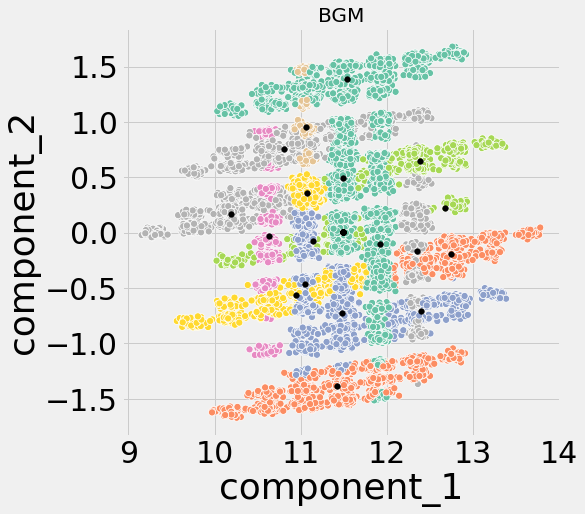

In [22]:
plt.close()
import scipy


preprocessor = Pipeline(
    [
        ("truncated_svd", TruncatedSVD(n_components=n_components, n_iter=7, 
                                       random_state=42)),    ]
)


clusterer = Pipeline(
   [
       algo
   ]
)


pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

data = feature_array
pipe.fit(data)

fig, axes = plt.subplots(figsize=(7,7))
plt.style.use("fivethirtyeight")

pcadf = pd.DataFrame(
pipe["preprocessor"].transform(data),
columns=["component_1", "component_2"],
)


predicted_labels =  pipe["clusterer"]["BGM"].predict(pipe["preprocessor"].transform(data))

pcadf["predicted_cluster"] = predicted_labels

#import ipdb
#ipdb.set_trace()

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    palette="Set2", ax=axes, #Paired
)

scat.set_title(
    algo_labels[i_algo]
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
axes.get_legend().set_visible(False)

gmm = pipe["clusterer"]["BGM"]
X = pipe["preprocessor"].transform(data)

centers = np.empty(shape=(gmm.n_components, X.shape[1]))

for i in range(gmm.n_components):
    density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
    centers[i, :] = X[np.argmax(density)]
    
    location_i = np.where(X == centers[i])[0][0]
    #print(centers[i], X[location_i])
    
    
plt.scatter(centers[:, 0], centers[:, 1], s=32, c="k")



#index_closest
print(centers.shape, len(set(predicted_labels)))
plt.show()

In [23]:
data.shape

(10000, 58)

In [24]:
list_indices_centroids_original = list()

for i in range(gmm.n_components):
    density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
    centers[i, :] = X[np.argmax(density)]
    
    location_i = np.where(X == centers[i])[0][0]
    list_indices_centroids_original.append(location_i)

centroids_data = data[list_indices_centroids_original]

In [25]:
#centroids_data[:, -5:]

centroid_idx_i = list_indices_centroids_original[1]
are_identical = list()

for centroid_idx_i in list_indices_centroids_original:
    centroid_specs_0 = extra_specs[centroid_idx_i]

    m0, ops0, _ = centroid_specs_0
    len_0 = m0.flatten('C').shape[0]
    bool_check = np.all(m0.flatten('C') == feature_array[centroid_idx_i][:len_0].astype(int)) #, len_0
    
    are_identical.append(bool_check)
    
are_identical, len(are_identical)

([True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True],
 27)

## Using the Binary Encoding

In [26]:
n_clusters = 20
n_components = 2

In [27]:
algo = (
           "BGM",
           BayesianGaussianMixture(n_components=n_clusters, covariance_type='full',
           random_state=42,
           weight_concentration_prior_type="dirichlet_distribution",
           max_iter=500,
                                  )
       )

(20, 2) 12


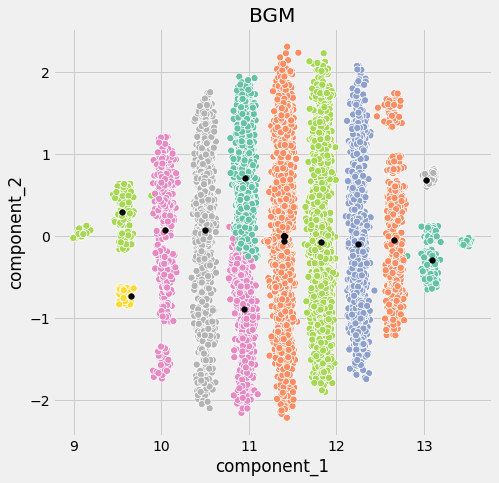

In [28]:
import scipy
plt.close()

preprocessor = Pipeline(
    [
        ("truncated_svd", TruncatedSVD(n_components=n_components, n_iter=7, 
                                       random_state=42)),    ]
)


clusterer = Pipeline(
   [
       algo
   ]
)


pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

data = feature_binary_array
pipe.fit(data)

fig, axes = plt.subplots(figsize=(7,7))
plt.style.use("fivethirtyeight")


pcadf = pd.DataFrame(
pipe["preprocessor"].transform(data),
columns=["component_1", "component_2"],
)


predicted_labels =  pipe["clusterer"]["BGM"].predict(pipe["preprocessor"].transform(data))

pcadf["predicted_cluster"] = predicted_labels

#import ipdb
#ipdb.set_trace()

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    palette="Set2", ax=axes, #Paired
)

scat.set_title(
    algo_labels[i_algo]
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
axes.get_legend().set_visible(False)

gmm = pipe["clusterer"]["BGM"]
X = pipe["preprocessor"].transform(data)

centers = np.empty(shape=(gmm.n_components, X.shape[1]))

for i in range(gmm.n_components):
    density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
    centers[i, :] = X[np.argmax(density)]
    
    location_i = np.where(X == centers[i])[0][0]
    #print(centers[i], X[location_i])
    
    
plt.scatter(centers[:, 0], centers[:, 1], s=32, c="k")



#index_closest
print(centers.shape, len(set(predicted_labels)))

plt.show()

In [29]:
list_indices_centroids_binary = list()

for i in range(gmm.n_components):
    density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
    centers[i, :] = X[np.argmax(density)]
    
    location_i = np.where(X == centers[i])[0][0]
    list_indices_centroids_binary.append(location_i)

centroids_data = data[list_indices_centroids_binary]

In [30]:
#centroids_data[:, -5:]

centroid_idx_i = list_indices_centroids_binary[1]
are_identical = list()

for centroid_idx_i in list_indices_centroids_binary:
    centroid_specs_0 = extra_specs[centroid_idx_i]

    m0, ops0, _ = centroid_specs_0
    len_0 = m0.flatten('C').shape[0]
    bool_check = np.all(m0.flatten('C') == feature_array[centroid_idx_i][:len_0].astype(int)) #, len_0
    
    are_identical.append(bool_check)
    
are_identical, len(are_identical)

([True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True],
 20)

### Configuration of it

### Using those models to init a GA

In [ ]:
dict_centroids = dict()
for c_i in list_indices_centroids_original:
    dict_centroids[int(c_i)] = [extra_specs[c_i][0].tolist(), extra_specs[c_i][1]]

    
import json

#with open('centroids_N27.json', 'w') as fp:
#    json.dump(dict_centroids, fp)
        

In [ ]:
len(dict_centroids)

In [ ]:
dict_centroids_binary = dict()
for c_i in list_indices_centroids_binary:
    dict_centroids_binary[int(c_i)] = [extra_specs[c_i][0].tolist(), extra_specs[c_i][1]]

    
import json

with open('centroids_N13_binary.json', 'w') as fp:
    json.dump(dict_centroids_binary, fp)
        

In [ ]:
len(dict_centroids_binary), len(set(list_indices_centroids_binary)), 10

In [ ]:
len(list_indices_centroids_original), len(set(list_indices_centroids_original)), list_indices_centroids_original

In [79]:
def random_spec():
  """Returns a random valid spec."""
  while True:
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
    matrix = np.triu(matrix, 1)
    ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
    ops[0] = INPUT
    ops[-1] = OUTPUT
    spec = api.ModelSpec(matrix=matrix, ops=ops)
    if nasbench.is_valid(spec):
      return spec

def mutate_spec(old_spec, mutation_rate=1.0):
  """Computes a valid mutated spec from the old_spec."""
  while True:
    new_matrix = copy.deepcopy(old_spec.original_matrix)
    new_ops = copy.deepcopy(old_spec.original_ops)

    # In expectation, V edges flipped (note that most end up being pruned).
    edge_mutation_prob = mutation_rate / NUM_VERTICES
    for src in range(0, NUM_VERTICES - 1):
      for dst in range(src + 1, NUM_VERTICES):
        if random.random() < edge_mutation_prob:
          new_matrix[src, dst] = 1 - new_matrix[src, dst]
          
    # In expectation, one op is resampled.
    op_mutation_prob = mutation_rate / OP_SPOTS
    for ind in range(1, NUM_VERTICES - 1):
      if random.random() < op_mutation_prob:
        available = [o for o in nasbench.config['available_ops'] if o != new_ops[ind]]
        new_ops[ind] = random.choice(available)
        
    new_spec = api.ModelSpec(new_matrix, new_ops)
    if nasbench.is_valid(new_spec):
      return new_spec


def random_combination(iterable, sample_size):
  """Random selection from itertools.combinations(iterable, r)."""
  pool = tuple(iterable)
  n = len(pool)
  indices = sorted(random.sample(range(n), sample_size))
  return tuple(pool[i] for i in indices)

In [ ]:
def run_random_search(max_time_budget=5e6, N_epochs=108):
  """Run a single roll-out of random search to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  while True:
    spec = random_spec()
    data = nasbench.query(spec, epochs=N_epochs)

    # It's important to select models only based on validation accuracy, test
    # accuracy is used only for comparing different search trajectories.
    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    if time_spent > max_time_budget:
      # Break the first time we exceed the budget.
      break

  return times, best_valids, best_tests

def run_evolution_search(max_time_budget=5e6,
                         population_size=50,
                         tournament_size=10,
                         mutation_rate=1.0, 
                         boosted=False, N_epochs=108, 
                         reference_specs=extra_specs, 
                         local_indices_centroids=None):
  """Run a single roll-out of regularized evolution to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  population = []   # (validation, spec) tuples

  # For the first population_size individuals, seed the population with randomly
  # generated cells.
  
  if local_indices_centroids is None:
     local_indices_centroids = range(population_size)   
    
  for idx_centroid in local_indices_centroids:
    
    if boosted:        
        spec = reference_specs[idx_centroid][2]
    else:
        spec = random_spec()
    #print(idx_centroid)
    
    #import ipdb
    #ipdb.set_trace()
    
    #print(spec, random_spec())
    data = nasbench.query(spec, epochs=N_epochs)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    population.append((data['validation_accuracy'], spec))

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  # After the population is seeded, proceed with evolving the population.
  while True:
    sample = random_combination(population, tournament_size)
    best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
    new_spec = mutate_spec(best_spec, mutation_rate)

    data = nasbench.query(new_spec, epochs=N_epochs)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)

    # In regularized evolution, we kill the oldest individual in the population.
    population.append((data['validation_accuracy'], new_spec))
    population.pop(0)

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  return times, best_valids, best_tests
  

In [ ]:
def run_evolution_search_updated(logger, max_time_budget=5e6,
                         population_size=50,
                         tournament_size=10,
                         mutation_rate=1.0, 
                         boosted=False, N_epochs=108,                                 
                         local_indices_centroids=None,
                         reference_specs=extra_specs, 
                         num_max_iterations=2000):    
  """Run a single roll-out of regularized evolution to a fixed time budget."""

  # Logging 
  stats = tools.Statistics(lambda ind: ind[0])
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)  

  logbook = tools.Logbook()
  logbook.header = "gen", "nevals", "avg", "std", "min", "max" 
    

  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  population = []   # (validation, spec) tuples
  iter_i = 0 
  best_seen = {'test_accuracy': -1, 'data': None}
  
  # For the first population_size individuals, seed the population with randomly
  # generated cells.
  
  if local_indices_centroids is None:
     local_indices_centroids = range(population_size)   
    
  for idx_centroid in local_indices_centroids:
    
    if boosted:        
        spec = reference_specs[idx_centroid][2]
        #print("boosted")
    else:
        spec = random_spec()
    #print(idx_centroid)
    
    #import ipdb
    #ipdb.set_trace()
    
    #print(spec, random_spec())
    data = nasbench.query(spec, epochs=N_epochs)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    population.append((data['validation_accuracy'], spec))

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])
    
    if data['test_accuracy'] > best_seen["test_accuracy"]:
        best_seen['data'] = data.copy()
        #best_seen['spec'] = spec.copy()
        best_seen["test_accuracy"] = data['test_accuracy']
    #ajd_i = data["module_adjacency"]
    #ops_i = data["module_operations"]
    #ops_i.remove("input")
    #ops_i.remove("output")
    #solution_i = ajd_i.tolist() + ops_i
    #logger.info(json.dumps({
    #'solution': solution_i,
    #'fitness': data[validation_accuracy],
    #'train_accuracy': data['train_accuracy'],
    #'validation_accuracy': data['validation_accuracy'],
    #'test_accuracy': data['test_accuracy'],
    #'epochs': epochs
    #}))
  
  record = stats.compile(population)
  logbook.record(gen=0, evals=population_size, **record)
  
  # After the population is seeded, proceed with evolving the population.
  while True:
    sample = random_combination(population, tournament_size)
    best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
    new_spec = mutate_spec(best_spec, mutation_rate)

    data = nasbench.query(new_spec, epochs=N_epochs)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)

    # In regularized evolution, we kill the oldest individual in the population.
    population.append((data['validation_accuracy'], new_spec))
    population.pop(0)
    iter_i += 1
    
    
    #ajd_i = data["module_adjacency"]
    #ops_i = data["module_operations"]
    #ops_i.remove("input")
    #ops_i.remove("output")
    #solution_i = ajd_i.tolist() + ops_i
    #logger.info(json.dumps({
    #'solution': solution_i,
    #'fitness': data[validation_accuracy],
    #'train_accuracy': data['train_accuracy'],
    #'validation_accuracy': data['validation_accuracy'],
    #'test_accuracy': data['test_accuracy'],
    #'epochs': epochs
    #}))
    
    record = stats.compile(population)
    logbook.record(gen=iter_i, evals=1, **record)

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])
    
    if data['test_accuracy'] > best_seen["test_accuracy"]:
        best_seen['data'] = data.copy()
        #best_seen['spec'] = spec.copy()
        best_seen["test_accuracy"] = data['test_accuracy']

    if iter_i >= num_max_iterations:
        break
    #if time_spent > max_time_budget:
    #  break
    #print(logbook)
    
  logger.info(logbook)
    
  ajd_i = best_seen['data']["module_adjacency"]
  ops_i = best_seen['data']["module_operations"]
  ops_i.remove("input")
  ops_i.remove("output")
  solution_i = ajd_i.tolist() + ops_i
  logger.info(json.dumps({
    'solution': solution_i,
    'fitness': data["validation_accuracy"],
    'train_accuracy': data['train_accuracy'],
    'validation_accuracy': data['validation_accuracy'],
    'test_accuracy': data['test_accuracy'],
    'epochs': N_epochs
    }))
    
  return times, best_valids, best_tests

In [34]:
from deap import tools
import logging

formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')


def setup_logger(name, log_file, level=logging.INFO):
  handler = logging.FileHandler(log_file)        
  handler.setFormatter(formatter)
  logger = logging.getLogger(name)
  logger.setLevel(level)
  logger.addHandler(handler)
  return logger


In [ ]:
N_epochs = 36
max_iterations = 2000
N_seeds = 100
np.random.seed(66666)

for idx_seed in range(N_seeds):
  seed = idx_seed 
    
  # random initialization
  logfile = "experiments/short_encoding/AgingEvol.rand." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_rand = setup_logger(logfile, logfile)
  times, best_valid, best_test = run_evolution_search_updated(N_epochs=N_epochs, 
                                                      population_size=len(list_indices_centroids_original), 
                                                      num_max_iterations=2000, logger=logger_rand)
  
  # centroid-based initialization
  logfile = "experiments/short_encoding/AgingEvol.centroids." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_centroids = setup_logger(logfile, logfile)
  times, best_valid, best_test = run_evolution_search_updated(N_epochs=N_epochs, boosted=True, 
                                                      population_size=len(list_indices_centroids_original), 
                                                      local_indices_centroids=list_indices_centroids_original, 
                                                      num_max_iterations=2000, logger=logger_centroids)

In [ ]:
N_epochs = 108
max_iterations = 2000


for idx_seed in range(N_seeds):
  seed = idx_seed

  # random initialization
  logfile = "experiments/short_encoding/AgingEvol.rand." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_rand = setup_logger(logfile, logfile)
  times, best_valid, best_test = run_evolution_search_updated(N_epochs=N_epochs, 
                                                      population_size=len(list_indices_centroids_original), 
                                                      num_max_iterations=2000, logger=logger_rand)
  
  # centroid-based initialization
  logfile = "experiments/short_encoding/AgingEvol.centroids." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_centroids = setup_logger(logfile, logfile)
  times, best_valid, best_test = run_evolution_search_updated(N_epochs=N_epochs, boosted=True, 
                                                      population_size=len(list_indices_centroids_original), 
                                                      local_indices_centroids=list_indices_centroids_original, 
                                                      num_max_iterations=2000, logger=logger_centroids)
  

In [ ]:
N_epochs = 36
max_iterations = 2000


for idx_seed in range(N_seeds):
  seed = idx_seed
    
  # random initialization
  logfile = "experiments/long_encoding/AgingEvol.rand." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_rand = setup_logger(logfile, logfile)
  times, best_valid, best_test = run_evolution_search_updated(N_epochs=N_epochs, 
                                                      population_size=len(list_indices_centroids_binary), 
                                                      num_max_iterations=max_iterations, logger=logger_rand)
  
  # centroid-based initialization
  logfile = "experiments/long_encoding/AgingEvol.centroids." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_centroids = setup_logger(logfile, logfile)
  times, best_valid, best_test = run_evolution_search_updated(N_epochs=N_epochs, boosted=True, 
                                                      population_size=len(list_indices_centroids_binary), 
                                                      local_indices_centroids=list_indices_centroids_binary, 
                                                      num_max_iterations=max_iterations, logger=logger_centroids)
  

In [ ]:
N_epochs = 108
max_iterations = 2000


for idx_seed in range(N_seeds):
  seed = idx_seed
    
  # random initialization
  logfile = "experiments/long_encoding/AgingEvol.rand." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_rand = setup_logger(logfile, logfile)
  times, best_valid, best_test = run_evolution_search_updated(N_epochs=N_epochs, 
                                                      population_size=len(list_indices_centroids_binary), 
                                                      num_max_iterations=max_iterations, logger=logger_rand)
  
  # centroid-based initialization
  logfile = "experiments/long_encoding/AgingEvol.centroids." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_centroids = setup_logger(logfile, logfile)
  times, best_valid, best_test = run_evolution_search_updated(N_epochs=N_epochs, boosted=True, 
                                                      population_size=len(list_indices_centroids_binary), 
                                                      local_indices_centroids=list_indices_centroids_binary, 
                                                      num_max_iterations=max_iterations, logger=logger_centroids)
  

In [ ]:
import json
def run_random_search_updated(logger, num_max_iterations=2000, N_epochs=108):
  """Run a single roll-out of random search to a fixed time budget."""
    
  ## logging
  # Logging 
  stats = tools.Statistics(lambda ind: ind[0])
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)  

  ##logbook = tools.Logbook()
  #logbook.header = "gen", "nevals", "avg", "std", "min", "max"

  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  best_seen = {'test_accuracy': -1, 'data': None}
  iter_i = 0

  while True:
    spec = random_spec()
    data = nasbench.query(spec, epochs=N_epochs)

    # It's important to select models only based on validation accuracy, test
    # accuracy is used only for comparing different search trajectories.
    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if iter_i >= num_max_iterations:
        break
        
    if data['test_accuracy'] > best_seen["test_accuracy"]:
        best_seen['data'] = data.copy()
        #best_seen['spec'] = spec.copy()
        best_seen["test_accuracy"] = data['test_accuracy']
    iter_i += 1
    
    if iter_i >= num_max_iterations:
        break
    #if time_spent > max_time_budget:
    #  break
    #print(logbook)
    
  #logger.info(logbook)

  ajd_i = best_seen['data']["module_adjacency"]
  ops_i = best_seen['data']["module_operations"]
  ops_i.remove("input")
  ops_i.remove("output")
  solution_i = ajd_i.tolist() + ops_i
  logger.info(json.dumps({
    'solution': solution_i,
    'fitness': data["validation_accuracy"],
    'train_accuracy': data['train_accuracy'],
    'validation_accuracy': data['validation_accuracy'],
    'test_accuracy': data['test_accuracy'],
    'epochs': N_epochs
    }))
  return times, best_valids, best_tests

In [ ]:
N_epochs = 36
max_iterations = 2000
N_seeds = 100

for idx_seed in range(N_seeds):
  seed = idx_seed
    
  # random search
  #logfile = "experiments/short_encoding/RS.rand." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_RS = setup_logger(logfile, logfile)
  _,_,test_RS = run_random_search_updated(logger_RS, num_max_iterations=max_iterations, N_epochs=N_epochs)
  assert len(test_RS) == max_iterations +1

In [ ]:
N_epochs = 108
max_iterations = 2000
N_seeds = 100


for idx_seed in range(N_seeds):
  seed = idx_seed
    
  # random search
  #logfile = "experiments/short_encoding/RS.rand." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_RS = setup_logger(logfile, logfile)
  _,_,test_RS = run_random_search_updated(logger_RS, num_max_iterations=max_iterations, N_epochs=N_epochs)
  assert len(test_RS) == max_iterations +1

In [ ]:
N_epochs = 36
max_iterations = 2000


for idx_seed in range(N_seeds):
  seed = idx_seed
    
  # random search
  #logfile = "experiments/long_encoding//RS.rand." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_RS = setup_logger(logfile, logfile)
  _,_,test_RS = run_random_search_updated(logger_RS, num_max_iterations=max_iterations, N_epochs=N_epochs)
  assert len(test_RS) == max_iterations +1

In [ ]:
N_epochs = 108
max_iterations = 2000

for idx_seed in range(N_seeds):
  seed = idx_seed
    
  # random search
  #logfile = "experiments/long_encoding//RS.rand." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_RS = setup_logger(logfile, logfile)
  _,_,test_RS = run_random_search_updated(logger_RS, num_max_iterations=max_iterations, N_epochs=N_epochs)
  assert len(test_RS) == max_iterations +1

In [36]:
NASBENCH_TFRECORD = '/local_home/trao_ka/data/nasbench_full.tfrecord'

INPUT = 'input'
OUTPUT = 'output'
CONV1X1 = 'conv1x1-bn-relu'
CONV3X3 = 'conv3x3-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'

MODEL_DIR = './models/'

MAX_VERTICES = 7
MAX_EDGES = 9

#nasbench = api.NASBench(NASBENCH_TFRECORD, seed=31081984)
adj_size = int(MAX_VERTICES * (MAX_VERTICES - 1) / 2)


def generate_lhs(size=50):
  #TODO update the size accordingly with the number of centroids
  sampling = lhs(adj_size, samples=size)
  adj_matrices = np.round(sampling).astype(int)
  ops = lhs(MAX_VERTICES - 2, samples=size)
  def sel_op(x):
    if x < 1/3:
      return CONV1X1
    elif x < 2/3:
      return CONV3X3
    else:
      return MAXPOOL3X3
  lhs_design = []
  for ix in range(size):
    encoded = adj_matrices[ix].tolist() + [sel_op(x) for x in ops[ix]]
    lhs_design.append(encoded)
  return lhs_design


LHS_design = None


def lhs_init():
  global LHS_design
  encoded = None
  for i in range(2):
    try:
      encoded = next(LHS_design)
    except:
      LHS_design = iter(generate_lhs())
    else:
      break
  return encoded

In [ ]:
lhs_samples = generate_lhs()

In [ ]:
x = lhs_samples[0]
for idx_i, x_i in enumerate(lhs_samples):
    
    N_epochs = 36
    adj_matrix = np.zeros((MAX_VERTICES,MAX_VERTICES), dtype=np.int8)
    adj_matrix[np.triu_indices(MAX_VERTICES, k=1)] = x_i[:adj_size]
    ops = [INPUT] + x_i[adj_size:] + [OUTPUT]
    model_spec = api.ModelSpec(
      matrix=adj_matrix,
      ops=ops)
    data = {
      'train_accuracy': 0,
      'validation_accuracy': 0,
      'test_accuracy': 0}
    if nasbench.is_valid(model_spec):
        data = nasbench.query(model_spec, epochs=N_epochs)
        fitness = data["test_accuracy"]
        print(idx_i)

In [31]:
list_indices_centroids_original[0]

3457

In [80]:
def run_evolution_search_updated(logger, max_time_budget=5e6,
                         population_size=50,
                         tournament_size=10,
                         mutation_rate=1.0, 
                         boosted=False, N_epochs=108,                                 
                         local_indices_centroids=None,
                         reference_specs=extra_specs, 
                         num_max_iterations=2000, lhs=False):    
  """Run a single roll-out of regularized evolution to a fixed time budget."""

  # Logging 
  stats = tools.Statistics(lambda ind: ind[0])
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)  

  logbook = tools.Logbook()
  logbook.header = "gen", "nevals", "avg", "std", "min", "max" 
    

  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  population = []   # (validation, spec) tuples
  iter_i = 0 
  best_seen = {'test_accuracy': -1, 'data': None}
  
  # For the first population_size individuals, seed the population with randomly
  # generated cells.
  
  if local_indices_centroids is None:
     local_indices_centroids = range(population_size)
     if lhs:
         lhs_init_pop = generate_lhs(size=len(local_indices_centroids)*3)
    
  for idx_centroid in local_indices_centroids:
    
    if boosted:        
        spec = reference_specs[idx_centroid][2]
        #print("boosted")
    elif boosted == False and lhs == True:
        #print('LHS idx: ', idx_centroid)
        x_i = lhs_init_pop[idx_centroid]
        adj_matrix = np.zeros((MAX_VERTICES,MAX_VERTICES), dtype=np.int8)
        adj_matrix[np.triu_indices(MAX_VERTICES, k=1)] = x_i[:adj_size]
        ops = [INPUT] + x_i[adj_size:] + [OUTPUT]
        spec = api.ModelSpec(
          matrix=adj_matrix,
          ops=ops)
        if nasbench.is_valid(spec):
            pass
        else:
           spec = random_spec()
           #print(spec)
        
        
    else:
        spec = random_spec()
    
    #print(idx_centroid)
    
    #import ipdb
    #ipdb.set_trace()
    
    #print(spec, random_spec())
    data = nasbench.query(spec, epochs=N_epochs)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    population.append((data['validation_accuracy'], spec))

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])
    
    if data['test_accuracy'] > best_seen["test_accuracy"]:
        best_seen['data'] = data.copy()
        #best_seen['spec'] = spec.copy()
        best_seen["test_accuracy"] = data['test_accuracy']
    #ajd_i = data["module_adjacency"]
    #ops_i = data["module_operations"]
    #ops_i.remove("input")
    #ops_i.remove("output")
    #solution_i = ajd_i.tolist() + ops_i
    #logger.info(json.dumps({
    #'solution': solution_i,
    #'fitness': data[validation_accuracy],
    #'train_accuracy': data['train_accuracy'],
    #'validation_accuracy': data['validation_accuracy'],
    #'test_accuracy': data['test_accuracy'],
    #'epochs': epochs
    #}))
  
  record = stats.compile(population)
  logbook.record(gen=0, evals=population_size, **record)
  
  # After the population is seeded, proceed with evolving the population.
  while True:
    sample = random_combination(population, tournament_size)
    best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
    new_spec = mutate_spec(best_spec, mutation_rate)

    data = nasbench.query(new_spec, epochs=N_epochs)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)

    # In regularized evolution, we kill the oldest individual in the population.
    population.append((data['validation_accuracy'], new_spec))
    population.pop(0)
    iter_i += 1
    
    
    #ajd_i = data["module_adjacency"]
    #ops_i = data["module_operations"]
    #ops_i.remove("input")
    #ops_i.remove("output")
    #solution_i = ajd_i.tolist() + ops_i
    #logger.info(json.dumps({
    #'solution': solution_i,
    #'fitness': data[validation_accuracy],
    #'train_accuracy': data['train_accuracy'],
    #'validation_accuracy': data['validation_accuracy'],
    #'test_accuracy': data['test_accuracy'],
    #'epochs': epochs
    #}))
    
    record = stats.compile(population)
    logbook.record(gen=iter_i, evals=1, **record)

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])
    
    if data['test_accuracy'] > best_seen["test_accuracy"]:
        best_seen['data'] = data.copy()
        #best_seen['spec'] = spec.copy()
        best_seen["test_accuracy"] = data['test_accuracy']

    if iter_i >= num_max_iterations:
        break
    #if time_spent > max_time_budget:
    #  break
    #print(logbook)
    
  logger.info(logbook)
    
  ajd_i = best_seen['data']["module_adjacency"]
  ops_i = best_seen['data']["module_operations"]
  ops_i.remove("input")
  ops_i.remove("output")
  solution_i = ajd_i.tolist() + ops_i
  logger.info(json.dumps({
    'solution': solution_i,
    'fitness': data["validation_accuracy"],
    'train_accuracy': data['train_accuracy'],
    'validation_accuracy': data['validation_accuracy'],
    'test_accuracy': data['test_accuracy'],
    'epochs': N_epochs
    }))
    
  return times, best_valids, best_tests

In [81]:
import json

In [84]:
N_seeds = 100
max_iterations = 2000

N_epochs = 36


for idx_seed in range(N_seeds):
  seed = idx_seed
    
  # lhs initialization
  logfile = "experiments/short_encoding/AgingEvol.lhs." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_lhs = setup_logger(logfile, logfile)
  times, best_valid, best_test = run_evolution_search_updated(N_epochs=N_epochs, 
                                                      population_size=len(list_indices_centroids_original), 
                                                      num_max_iterations=max_iterations, logger=logger_lhs, 
                                                              lhs=True)

In [85]:
N_epochs = 108

for idx_seed in range(N_seeds):
  seed = idx_seed
    
  # lhs initialization
  logfile = "experiments/short_encoding/AgingEvol.lhs." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_lhs = setup_logger(logfile, logfile)
  times, best_valid, best_test = run_evolution_search_updated(N_epochs=N_epochs, 
                                                      population_size=len(list_indices_centroids_original), 
                                                      num_max_iterations=max_iterations, logger=logger_lhs, 
                                                              lhs=True)

In [86]:
#N_seeds = 10
max_iterations = 2000

N_epochs = 36


for idx_seed in range(N_seeds):
  seed = idx_seed
    
  # lhs initialization
  logfile = "experiments/long_encoding/AgingEvol.lhs." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_lhs = setup_logger(logfile, logfile)
  times, best_valid, best_test = run_evolution_search_updated(N_epochs=N_epochs, 
                                                      population_size=len(list_indices_centroids_binary), 
                                                      num_max_iterations=max_iterations, logger=logger_lhs, 
                                                              lhs=True)

In [87]:
N_epochs = 108

for idx_seed in range(N_seeds):
  seed = idx_seed
    
  # lhs initialization
  logfile = "experiments/long_encoding/AgingEvol.lhs." + str(N_epochs) + "e." + str(idx_seed) + ".log"
  logger_lhs = setup_logger(logfile, logfile)
  times, best_valid, best_test = run_evolution_search_updated(N_epochs=N_epochs, 
                                                      population_size=len(list_indices_centroids_binary), 
                                                      num_max_iterations=max_iterations, logger=logger_lhs, 
                                                              lhs=True)